# Módulo de Matemáticas 101: práctica

Vamos a poner de nuevo en práctica lo que hemos visto en este módulo. La práctica se centra en la regresión lineal (¡tema muy importante!) y podéis preguntarme las dudas que tengáis por Discord. ¡Mucha suerte!

## 1. Regresión lineal con mínimos cuadrados

En este ejercicio vamos a implementar la forma matricial de la regresión lineal con el método de los mínimos cuadrados. Para ello, tendrás que:

- Explorar un dataset
- Implementar la regresión lineal
- Aplicarla a un dataset concreto

Como recordatorio, los valores de los pesos $\widehat{w}$ vienen dados por:

<center>$\widehat{w} = (X^T X)^{-1}X^T y,$</center>

Donde $y$ es la variable a predecir y $X$ la matriz de features (NOTA: revisa cómo se define en los apuntes). Sabemos que los pesos van a ser los parámetros de la ecuación lineal que estamos intentando ajustar y tendremos uno por cada variable de entrada que usemos y además un término independiente o bias.

### 1.1 Carga del dataset y exploración de datos

Vamos a usar el dataset de [Auto MPG](https://archive.ics.uci.edu/dataset/9/auto+mpg) que podemos encontrar en el [repositorio de Machine learning de UC Irvine](https://archive.ics.uci.edu/). Lo primero, vamos a familiarizarnos con los datos.

En el propio repositorio nos indican cómo descargar el dataset con su librería (podemos consultar el código fuente si queremos).

In [153]:
!pip install ucimlrepo

In [154]:
from ucimlrepo import fetch_ucirepo 
  
# fetch dataset 
auto_mpg = fetch_ucirepo(id=9) 
  
# data (as pandas dataframes) 
X = auto_mpg.data.features 
print(X.shape)


y = auto_mpg.data.targets 
print(y.shape)
  
# metadata 
#print('esto es metadata',auto_mpg.metadata) 
  
# variable information 
print('esto es variables\n',auto_mpg.variables) 
print(auto_mpg.variables.shape)


(398, 7)
(398, 1)
esto es variables
            name     role         type demographic description units  \
0  displacement  Feature   Continuous        None        None  None   
1           mpg   Target   Continuous        None        None  None   
2     cylinders  Feature      Integer        None        None  None   
3    horsepower  Feature   Continuous        None        None  None   
4        weight  Feature   Continuous        None        None  None   
5  acceleration  Feature   Continuous        None        None  None   
6    model_year  Feature      Integer        None        None  None   
7        origin  Feature      Integer        None        None  None   
8      car_name       ID  Categorical        None        None  None   

  missing_values  
0             no  
1             no  
2             no  
3            yes  
4             no  
5             no  
6             no  
7             no  
8             no  
(9, 7)


Con la función `head` de Pandas podemos ver las primeras filas del dataset.

In [155]:
X.head()

,displacement,cylinders,horsepower,weight,acceleration,model_year,origin
0,307.0,8,130.0,3504,12.0,70,1
1,350.0,8,165.0,3693,11.5,70,1
2,318.0,8,150.0,3436,11.0,70,1
3,304.0,8,150.0,3433,12.0,70,1
4,302.0,8,140.0,3449,10.5,70,1


In [156]:
y.head()

,mpg
0,18.0
1,15.0
2,18.0
3,16.0
4,17.0


En este punto, puedes hacer cualquier otro análisis exploratorio que creas conveniente.

A continuación, crea una función a la que le pases los dataframes de features y de target y el nombre de la variable y haga la gráfica del target (consumo en millas por galón) vs la variable que le ha llegado por parámetro. Puedes ver un ejemplo de gráfica más abajo, pero usa los parámetros que quieras en cuanto a color de los puntos, grids etc.

(<Figure size 640x480 with 1 Axes>,
 <Axes: xlabel='horsepower', ylabel='MPG Consumption'>)

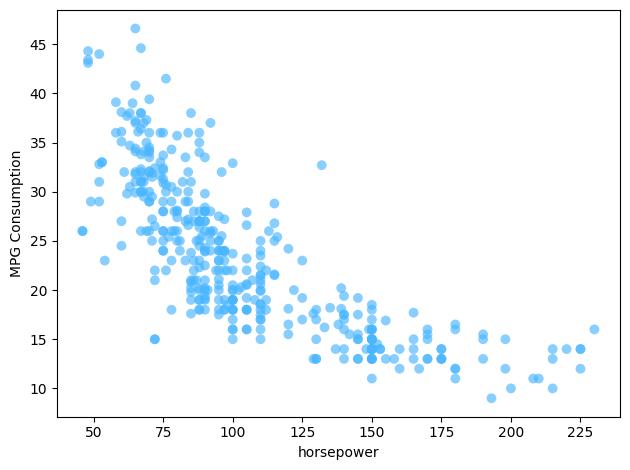

In [157]:
import matplotlib.pyplot as plt
import pandas as pd

def visualiza(df, y, nombre_columna):
    # Todo: dibuja la gráfica

    #Tomo los datos para graficar
    valores_x = df[nombre_columna]

    #Preparo la figura: Decido el color de la grafica en función del índice que tiene la columna que voy a graficar, así de forma atumatica se cambia el color
    #de la grafica según el dato ploteado.
    
    cmap = plt.get_cmap('cool')
    indice_max = df.shape[1]
    indice = df.columns.get_loc(key =f"{nombre_columna}")

    figure, ax = plt.subplots()
    ax.scatter(valores_x,y, s = 50, color= cmap(indice/indice_max), alpha=0.65, edgecolors='none') #Con alpha, para que se vea mejor donde hay solapamiento de puntos
    ax.set_xlabel(f"{nombre_columna}")
    ax.set_ylabel("MPG Consumption")
    plt.tight_layout()
    #plt.show()
    return figure, ax
    

visualiza(X, y, 'horsepower')

(<Figure size 640x480 with 1 Axes>,
 <Axes: xlabel='acceleration', ylabel='MPG Consumption'>)

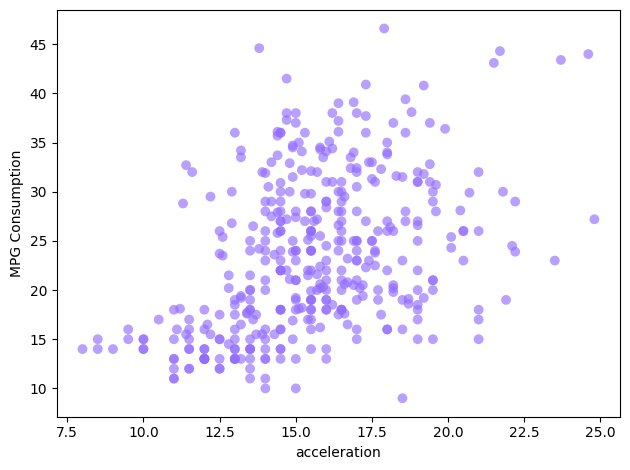

In [158]:
visualiza(X, y, 'acceleration')

(<Figure size 640x480 with 1 Axes>,
 <Axes: xlabel='weight', ylabel='MPG Consumption'>)

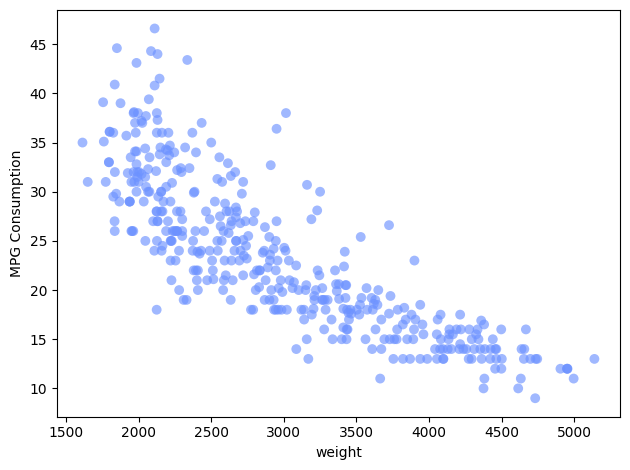

In [159]:
visualiza(X, y, 'weight')

IMPORTANTE: Aunque lo ideal sería un modelo multivariante, vamos a elegir la variable `weight` y hacer una regresión lineal solo con esta variable.

### 1.2 Implementación del modelo

En este punto vamos a dar un paso atrás y olvidarnos de los datos de consumo por un momento, porque el algoritmo que vamos a implementar serviría para cualquier conjunto de datos.

Lo primero, implementa una función que devuelva los valores de $\widehat{w}$ dados X e y. Si se da el caso de que el dataset tiene más features que observaciones, queremos transponerlo antes de realizar las operaciones. Lo hacemos porque, como vimos en clase, los resultados no van a ser buenos si el número de observaciones es menor.

In [168]:
import numpy as np

def pesos_ols(X, y):
    # Implementa la fórmula matricial
    
    # TODO 1 Comprueba que las dimensiones son adecuadas y corrige si no es así

    if X.shape[0] < X.shape[1]: #si el numero de filas (observaciones) es mas pequeño que el de columnas (variables)
        X=X.T
        print("La matriz X ha sido transpuesta, pues el numero de observaciones es menor al de variables")
        if X.shape[0] != y.shape[0]:
            y=y.T #Para cuando se hace el ejemplo el vector Y ya tiene 10 filas, aunque deberia tener tantas filas como la matriz X (cada observacion da un target, no?) O sea no deberia haber este if, sino directamente transponer ambas matrices

    # TODO 2 Prepara la matriz X para que tenga la forma adecuada para aplicar la fórmula 
    ones = np.ones((X.shape[0],1))
    X_b = np.hstack ((ones, X))

    # TODO 3 Calcula los pesos
    
    w, residuos, _, _= np.linalg.lstsq(X_b, y) #En el caso de que no se pueda calcular la inversa, se hace con este metodo que supone  ya la pseudo inversa


    return w

In [161]:
# Array de prueba!!
X = np.array([[1710, 1262, 1786, 1717, 2198, 1362, 1694, 2090, 1774, 1077], 
              [2003, 1976, 2001, 1915, 2000, 1993, 2004, 1973, 1931, 1939]])
y = np.array([208500, 181500, 223500, 140000, 250000, 143000, 307000, 200000, 129900, 118000])
print(pesos_ols(X, y))


La matriz X ha sido transpuesta, pues el numero de observaciones es menor al de variables
[-2.29223802e+06  5.92536529e+01  1.20780450e+03]


Hemos implementado el algoritmo de mínimos cuadrados y lo hemos probado en un array de tamaño 2x10. Como pista, el resultado que he obtenido para este array de prueba es el siguiente:

array([-2.29223802e+06,  5.92536529e+01,  1.20780450e+03])

### 1.3 Prueba del modelo en los datos de consumo de coches

Ya podemos usar nuestra función `pesos` en el dataset real que hemos descargado, el de consumo de combustible. Para ver el ajuste, dibuja de nuevo los datos junto con la recta que has obtenido, en la misma gráfica. Tendrás que convertir los dataframes de Pandas en arrays de numpy para poder aplicar las operaciones matriciales.

TIP: Revisa las dimensiones de todos los arrays para ver que son correctas.

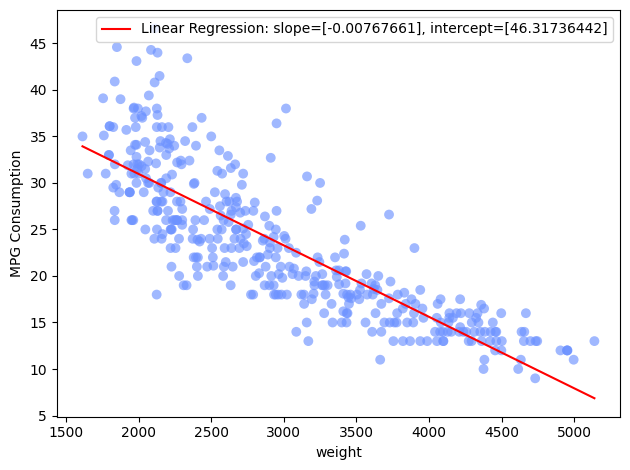

In [162]:
# TODO Aplica el modelo y dibuja la recta junto con los datos

#Cogemos los datos
X = auto_mpg.data.features 
y = auto_mpg.data.targets 

# Nos quedamos con solo la variable weight, e intentamos aplicar el modelo de los minimos cuadrados para hacer la regresion lineal.
figura, axis = visualiza(X, y, 'weight') #Dibujamos solo los datos consumption vs weight

coeficientes = pesos_ols(X[["weight"]], y) # Se calcula los pesos (intercept y slope en este caso 2D)

# Se va a pintar la recta obtenida para la regresion lineal, con los datos de slope y intercept obtenidos
# Para estar en en el mismo rango que la gráfica donde se visualiza los datos, hallamos los valores min y max de weight evaluados:
min = X["weight"].min()
max = X["weight"].max()

x_vals = np.linspace(min,max, 100)

# Calcular valores de y usando la recta
y_vals = coeficientes[0] + coeficientes[1] * x_vals

# Dibujar la recta
axis.plot(x_vals, y_vals, label=f"Linear Regression: slope={coeficientes[1]}, intercept={ coeficientes[0]}", color="red")
plt.legend(loc="upper right")
plt.show()

In [163]:
! pip install scikit-learn

Por último, vamos a comprar el resultado con el que nos da `scikit-learn`para ver si nuestra implementación tiene buena pinta. Podemos ver cómo funciona en la [documentación](https://scikit-learn.org/stable/modules/generated/sklearn.linear_model.LinearRegression.html).

In [164]:
from sklearn.linear_model import LinearRegression

# Creamos el objeto
lr = LinearRegression()

# Le pasamos los datos en el formato correcto
X = auto_mpg.data.features 
y = auto_mpg.data.targets 

X_lr = X[['weight']]
y_lr = y

# Entrenamos con los datos
lr.fit(X_lr,y_lr)
print("Punto de corte:", lr.intercept_)
print("Pendiente:", lr.coef_)

Punto de corte: [46.31736442]
Pendiente: [[-0.00767661]]


**TODO**: Analiza el resultado obtenido y compáralo con el de sklearn

Nos da los mismos valores con ambos métodos. Se puede confirmar que está bien.

### 1.4 Compara el método de mínimos cuadrados y el descenso del gradiente para obtener los coeficientes de una regresión lineal



El método de mínimos cuadrados en un método único para la regresión lineal. Se basa en conseguir los argumentos de la recta (slope y intercept en el caso de 2D), que hacen que la distancia al cuadrado entre el valor estimado por esa linea hipotética y el valor real de los datos sea mínima. En cambio, el descenso de gradiente es un método general para cuando se busca un modelo que siga tus datos reales, es decir, se puede implementar a más casos aparte de la regresión lineal. Con el método de descenso de gradiente hallamos los valores minimos de nuestra función objetivo, que nos dará las variable para nuestro modelo. En el caso de implementar el descenso de gradiente para una regresión lineal, la función objetivo (RSS) es muy parecida a la de mínimos cuadrados, solo que en este caso, la fórmula lleva un factor (1/2) delante multiplicando a esta suma al cuadrado de las distancias entre el valor real y el estimado. Este valor es para que, al hacer la derivada (necesaria en el método de descenso de gradiente), el cálculo esté más simplificado. Porque, al final, multiplicar o dividar tu función objetivo por un número no hace que varie el valor "x" que la hace mínima (que es lo que nos interesa para nuestro modelo), sino tan solo su valor en y, que poco importa.

En conclusión, ambos modelo en el caso de la regresión lineal hace practicamente lo mismo, pues buscan el minimo entre el valor real y el estimado, aunque el método de descenso de gradiente es más general.

## 2. Optimización con descenso del gradiente

Vamos a resolver el mismo problema usando el descenso del gradiente en lugar de la solución analítica. El descenso del gradiente es un método de optimización iterativo que usa el operador gradiente.

Como es iterativo, necesitamos decirle cuándo tiene que parar y darnos la solución. En este caso, le vamos a decir que pare y nos devuelva la solución después de un número de iteraciones que le pasaremos como parámetro. La ecuación iterativa es.

$$w^{t+1} = w^t - \eta \cdot \nabla f(w)$$

donde f es nuestra función objetivo, y w es un vector. Para la función objetivo, vamos a usar el error RSS, que querremos minimizar.

$$ RSS(w) = \frac{1}{2}\sum_{n=1}^{N}[y_n-f(x_n)]^2$$

y cuyo gradiente es:

$$\nabla RSS(w) = X^T(Xw^t-y)$$

TIP: Ten en cuenta que el RSS también lo puedes escribir como $\frac{1}{2}\sum_{n=1}^{N}[y_n-\hat{y_n}]^2$ donde $\hat{y_n} = X \hat{w}$ en cada paso.

### 2.1 Implementar el descenso del gradiente

Completa las siguientes funciones para implementar el descenso del gradiente con la función objetivo de la regresión lineal. La función necesitará:

- La entrada X y salida y de la regresión
- Un punto inicial desde el que empezar a iterar
- El número de iteraciones 
- El learning rate

La función nos devolverá un array con las w resultantes de las iteraciones y otro con el valor de la función en cada paso del algoritmo, a la que también se conoce como *loss function*.

(5, 1)
(5, 1)
[[183845.82320222]
 [ 40415.66453324]]


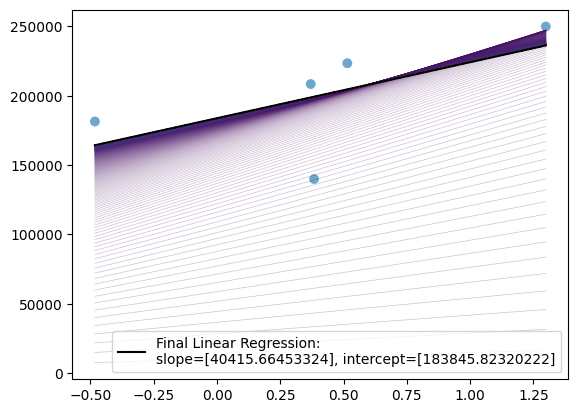

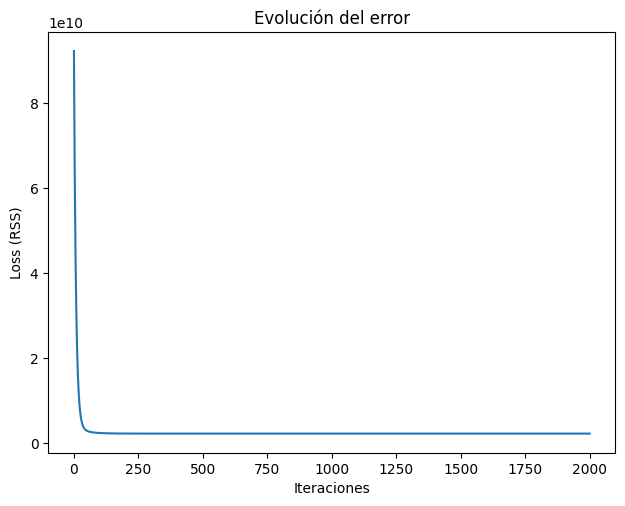

In [253]:
import numpy as np

def gradient_descent(X, y, w0, n_iter, eta):

    #Para visualizar el proceso a seguir, se crea dos figuras:

    fig_datos, ax_datos = plt.subplots()
    fig_error, ax_error = plt.subplots()
    ax_datos.scatter(X,y, s = 50, color= 'tab:blue', alpha=0.65, edgecolors='none') #Con alpha, para que se vea mejor donde hay solapamiento de puntos
    plt.tight_layout()
    min = X.min()
    max = X.max()
    x_vals = np.linspace(min,max, 100)

    #Inicializamos las varibales
    loss_iter = [np.inf]
    w_iter = [w0]
    w = w0
    max_number_iter = n_iter

    #Peparamos las matrices para que tengan la dimension correcta
    ones = np.ones((X.shape[0],1))
    X_b = np.hstack ((ones, X))

    #Comemenzamos a iterar (bucle tantas veces como numero de iteraciones se han definido)
    

    for n_iterac in range(max_number_iter):
        
        #Se define el gradiente de la funcion objetivo, y así los nuevos pesos
        grad_RSS = X_b.T @ ((X_b@w)-y)
        w = w - eta * grad_RSS
        
        #Se define el valor de la funcion objetivo a minimizar con los pesos obtenidos y se incluyen en el array
        f_w = (1/2)*np.sum((y-(X_b@w))**2)
        loss_iter.append(f_w)
        w_iter.append(w)

        #Pintamos los datos encontrados:
        
        y_vals = w[0] + w[1] * x_vals
        cmap = plt.get_cmap('viridis')
        ax_datos.plot(x_vals, y_vals, color=cmap(n_iterac/(max_number_iter - 1)), alpha = 0.25, linewidth=0.5)

    ax_datos.plot(x_vals, y_vals, label=f"Final Linear Regression:\nslope={w[1]}, intercept={ w[0]}", color="black", alpha = 1, linewidth=1.5)
    ax_datos.legend(loc="lower right")
    #Pintamos como se ha ido minimizando la funcion objetivo:
    ax_error.plot(np.arange(max_number_iter + 1), loss_iter)
    ax_error.set_title("Evolución del error")
    ax_error.set_xlabel("Iteraciones")
    ax_error.set_ylabel("Loss (RSS)")
    
    # Devuelve los resultados
    return np.array(w_iter), np.array(loss_iter)


eta = 0.01
iteraciones = 2000 

np.random.seed(123)
w0 = np.random.rand(2).reshape((2,1))

y = np.array([208500, 181500, 223500, 140000, 250000]).reshape((5,1))
X = np.array( [[  0.37020659],
               [  -0.48234664],
               [  0.51483616],
               [  0.38352774],
               [  1.29888065]])

print(X.shape)
print(y.shape)

weights, loss = gradient_descent(X, y, w0, iteraciones, eta)

print(weights[-1])

### 2.2 Aplicar al dataset de consumo de combustible

Leemos de nuevo los datos y aplicamos la función que acabamos de programar.

In [254]:
from ucimlrepo import fetch_ucirepo 
  
# fetch dataset 
auto_mpg = fetch_ucirepo(id=9) 
  
# data (as pandas dataframes) 
X = auto_mpg.data.features 
y = auto_mpg.data.targets 
  
# convert to numpy
X_np = X['weight'].to_numpy().reshape((X.shape[0], 1))
y_np = y.to_numpy()

print(X_np.shape)
print(y_np.shape)

(398, 1)
(398, 1)


Para ayudar al algoritmo, vamos a escalar la variable X, restando la media y dividiendo entre la desviación estándar. Después aplicamos la función anterior y dibujamos.

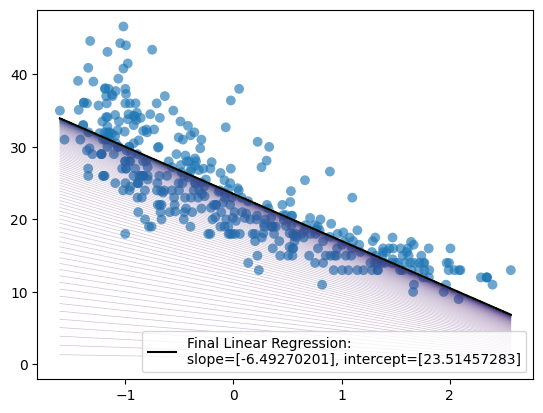

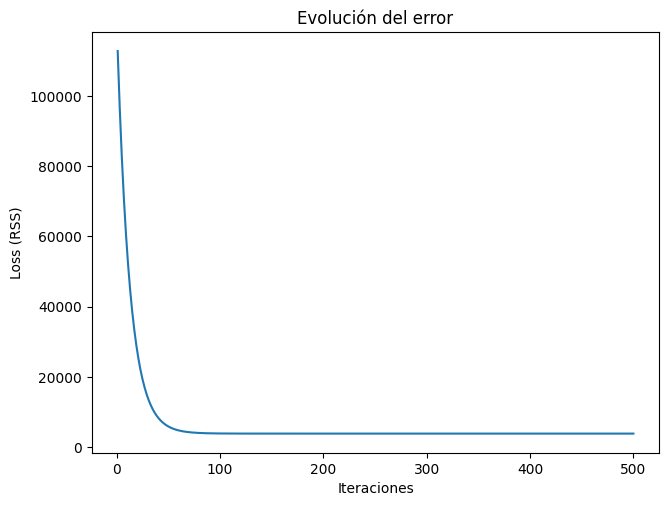

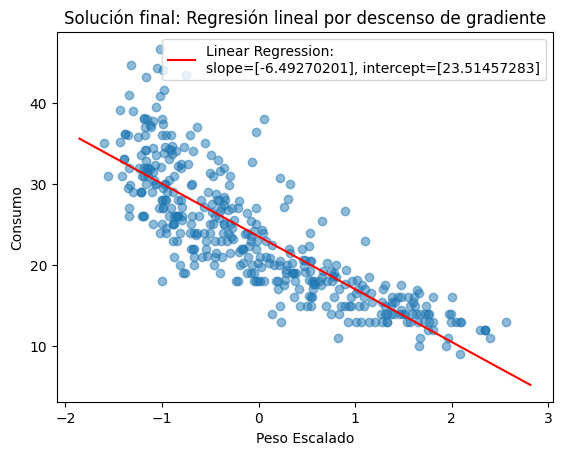

In [264]:
# Aplica el modelo y dibuja la recta junto con los datos

X = auto_mpg.data.features
y = auto_mpg.data.targets

# Escalamos la variable x 

X_np = X['weight'].to_numpy().reshape((X.shape[0], 1))
y_np = y.to_numpy()

X_gd=(X_np - X_np.mean()) / X_np.std()
y_gd = y_np

# Definimos Punto inicial y learning rate
w0 = np.array ([[0, 0]]).T
eta = 0.0001 
iteraciones = 500 

# Aplicamos el algoritmo
weights, loss = gradient_descent(X_gd, y_gd, w0, iteraciones, eta)

# Límites de los ejes
x_max = np.max(X_gd) + 0.25
x_min = np.min(X_gd) - 0.25

# 3 Dibuja la gráfica
figure_final, axis_final = plt.subplots()

x_vals = np.linspace(x_min,x_max, 100)
y_vals = weights[-1][0] + weights[-1][1] * x_vals
axis_final.plot(x_vals, y_vals, label=f"Linear Regression:\nslope={weights[-1][1]}, intercept={ weights[-1][0]}", color="red")
axis_final.scatter(X_gd, y_gd, color="tab:blue", alpha=0.5)

# Calcular valores de y usando la recta
axis_final.set_xlabel("Peso Escalado")
axis_final.set_ylabel("Consumo")
axis_final.legend(loc="upper right")
axis_final.set_title('Solución final: Regresión lineal por descenso de gradiente')

plt.show()
